# Great Energy Predictor - Modeling (Electricity Meters)
#### Hosted by: ASHRAE
##### Source: https://www.kaggle.com/c/ashrae-energy-prediction

## Section I: Dependencies and Data

### Dependencies

In [1]:
# Dependencies
import os
import gc
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
import optuna
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

import src.utils as udf

%matplotlib inline

In [2]:
# Dataframe settings
pd.set_option('display.max_columns', 50)

# Plot settings
mpl.style.use('seaborn')
mpl.rcParams['figure.figsize'] = (15, 3)
mpl.rcParams['font.size'] = 12

### Data

In [3]:
# Data path
data_path = os.path.join('..', 'data', '03-feat-out')
data_path

'../data/03-feat-out'

In [4]:
# Electricity meter data
electricity = pd.read_pickle(os.path.join(data_path, 'electricity.pkl'))
electricity.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11481619 entries, 0 to 18205341
Data columns (total 22 columns):
 #   Column              Dtype         
---  ------              -----         
 0   site_id             uint8         
 1   building_id         uint16        
 2   timestamp           datetime64[ns]
 3   meter_reading       float32       
 4   air_temperature     float32       
 5   dew_temperature     float32       
 6   rel_humidity        float32       
 7   sea_level_pressure  float32       
 8   wind_speed          float32       
 9   wind_direction_x    float32       
 10  wind_direction_y    float32       
 11  primary_use         object        
 12  square_feet         uint32        
 13  year_built          uint16        
 14  missing_year        uint8         
 15  country             object        
 16  dayofyear           uint16        
 17  month               uint8         
 18  hour                uint8         
 19  dayofweek           uint8         
 20  

In [5]:
# Chilled water meter data
chilledwater = pd.read_pickle(os.path.join(data_path, 'chilledwater.pkl'))
chilledwater.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3507966 entries, 70 to 18205292
Data columns (total 22 columns):
 #   Column              Dtype         
---  ------              -----         
 0   site_id             uint8         
 1   building_id         uint16        
 2   timestamp           datetime64[ns]
 3   meter_reading       float32       
 4   air_temperature     float32       
 5   dew_temperature     float32       
 6   rel_humidity        float32       
 7   sea_level_pressure  float32       
 8   wind_speed          float32       
 9   wind_direction_x    float32       
 10  wind_direction_y    float32       
 11  primary_use         object        
 12  square_feet         uint32        
 13  year_built          uint16        
 14  missing_year        uint8         
 15  country             object        
 16  dayofyear           uint16        
 17  month               uint8         
 18  hour                uint8         
 19  dayofweek           uint8         
 20  

In [6]:
# Steam meter data
steam = pd.read_pickle(os.path.join(data_path, 'steam.pkl'))
steam.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2296049 entries, 762 to 18205336
Data columns (total 22 columns):
 #   Column              Dtype         
---  ------              -----         
 0   site_id             uint8         
 1   building_id         uint16        
 2   timestamp           datetime64[ns]
 3   meter_reading       float32       
 4   air_temperature     float32       
 5   dew_temperature     float32       
 6   rel_humidity        float32       
 7   sea_level_pressure  float32       
 8   wind_speed          float32       
 9   wind_direction_x    float32       
 10  wind_direction_y    float32       
 11  primary_use         object        
 12  square_feet         uint32        
 13  year_built          uint16        
 14  missing_year        uint8         
 15  country             object        
 16  dayofyear           uint16        
 17  month               uint8         
 18  hour                uint8         
 19  dayofweek           uint8         
 20 

In [7]:
# Hot water meter data
hotwater = pd.read_pickle(os.path.join(data_path, 'hotwater.pkl'))
hotwater.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 919708 entries, 10 to 18205124
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   site_id             919708 non-null  uint8         
 1   building_id         919708 non-null  uint16        
 2   timestamp           919708 non-null  datetime64[ns]
 3   meter_reading       919708 non-null  float32       
 4   air_temperature     919708 non-null  float32       
 5   dew_temperature     919708 non-null  float32       
 6   rel_humidity        919708 non-null  float32       
 7   sea_level_pressure  919708 non-null  float32       
 8   wind_speed          919708 non-null  float32       
 9   wind_direction_x    919708 non-null  float32       
 10  wind_direction_y    919708 non-null  float32       
 11  primary_use         919708 non-null  object        
 12  square_feet         919708 non-null  uint32        
 13  year_built          919708

In [8]:
# Selected feats table
feats = pd.read_pickle(os.path.join(data_path, 'feats.pkl'))
feats

,target_corr,lasso_coef,lasso_coef_recursive,tree_importance,tree_importance_recursive
0,square_feet,primary_use,primary_use,square_feet,site_id
1,country,square_feet,square_feet,year_built,air_temperature
2,,country,missing_year,country,primary_use
3,,is_weekend,country,,square_feet
4,,,dayofyear,,year_built
5,,,hour,,country
6,,,is_weekend,,dayofyear
7,,,is_holiday,,hour


In [9]:
# Clean vars
del data_path
gc.collect()

26

## Section II: Featurization - Electricity

Once again, we will be working primarily with the electricity meter data as it contains the most readings and the process used here will be repeated for the other 3 meters.

### Drop unused features

We will be dropping the features we found to be unnecessary in the featurization notebook - `site_id`, `building_id`, `dew_temperature`, `timestamp`, `month`, `dayofweek`. `Site_id` was added here because we have the `country` feature which is a good proxy for it.

In [10]:
# Drop feats
to_drop = ['site_id', 'building_id', 'dew_temperature', 'timestamp', 'month', 'dayofweek']
electricity.drop(to_drop, axis=1, inplace=True)
electricity.head(3)

,meter_reading,air_temperature,rel_humidity,sea_level_pressure,wind_speed,wind_direction_x,wind_direction_y,primary_use,square_feet,year_built,missing_year,country,dayofyear,hour,is_weekend,is_holiday
0,12.603682,19.4,100.000000,1019.400024,0.0,0.0,0.000000,Parking,387638,1997,0,US,1,0,0,1
1,15.364478,19.4,100.000000,1019.400024,0.0,0.0,0.000000,Office,33370,1982,0,US,1,0,0,1
2,23.303600,3.8,90.549408,1020.900024,3.1,-0.5,-0.866025,Education,50623,1960,1,EU,1,0,0,1


### Train/test split

The same 70-12-18 data split will be done here. Variables will be suffixed with "e" to indicate that it is `electricity` meter data.

In [11]:
# Split feats and target
Xe = electricity.drop('meter_reading', axis=1).copy()
ye = electricity['meter_reading'].copy()
Xe.shape, ye.shape

((11481619, 15), (11481619,))

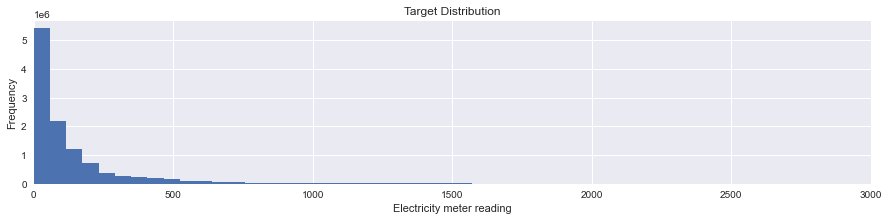

In [12]:
# Target distribution
ye.plot(kind='hist', bins=200, title='Target Distribution', xlim=(0, 3e3))
plt.xlabel('Electricity meter reading')
plt.show()

The raw meter readings are highly right-skewed. We may be able to get more accurate predictions if we transform the target variable into a normal distribution to increase its linearity with the features. To do this, we will do a log transformation on the target variable and train our models using the log-transformed target. Of course, when making predictions, the output will be log-transformed values, so the predictions will have to be inverse-transformed to yield the true output.

Note: the target variable contains meter readings of 0, so 1 will be added to all readings before taking the log (because log(0) is undefined) like this: `y_log_transformed = log(y + 1)`

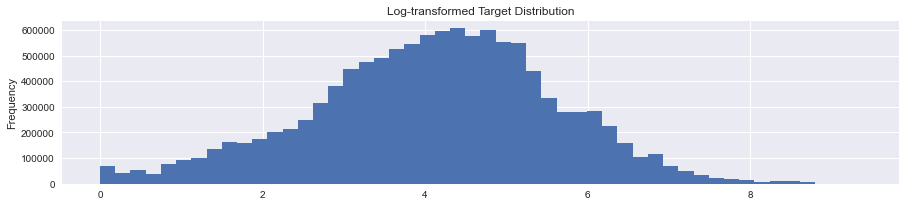

In [13]:
# Log transform the target var
ye_log = np.log1p(ye)
ye_log.plot.hist(bins=50, title='Log-transformed Target Distribution')
plt.show()

In [14]:
# Train/val/test split (70/12/18)
Xe_train, Xe_test, ye_train, ye_test = train_test_split(Xe, ye_log, test_size=0.3, random_state=30)
Xe_val, Xe_test, ye_val, ye_test = train_test_split(Xe_test, ye_test, test_size=0.6, random_state=30)

print('Train set:', Xe_train.shape, ye_train.shape)
print('Validation set:', Xe_val.shape, ye_val.shape)
print('Test set:', Xe_test.shape, ye_test.shape)

Train set: (8037133, 15) (8037133,)
Validation set: (1377794, 15) (1377794,)
Test set: (2066692, 15) (2066692,)


In [15]:
# Clean vars
del Xe, ye, ye_log
gc.collect()

24477

### Categorical feature encoding

Next, we will perform the 2 types of categorical encoding as in the featurization notebook:
1. Rare label categorical encoding - categorical labels that occur less than 5% in the data will be encoded as "Rare"
    - This will be done for `primary_use`
2. Mean target categorical encoding - categorical labels will be numerically encoded with the mean value of the target label for that particular label
    - This will be done for `primary_use` and `country`
    - Note: countries "UK" and "IE" were grouped into the label "EU"
    
The difference here is that the target label has been log-transformed, so the encoded values here will differ from the featurization notebook

In [16]:
# Group all rare primary use categories
Xe_train, Xe_val, Xe_test, rare_dict = udf.rare_encoder(['primary_use'], Xe_train, Xe_test, val=Xe_val)
rare_dict

{'primary_use': Index(['Education', 'Office', 'Entertainment/public assembly',
        'Public services', 'Lodging/residential'],
       dtype='object')}

In [17]:
# Primary use counts
print('##### Train set #####')
print(Xe_train['primary_use'].value_counts())
print('\n##### Validation set #####')
print(Xe_val['primary_use'].value_counts())
print('\n##### Test set #####')
print(Xe_test['primary_use'].value_counts())

##### Train set #####
Education                        3076745
Office                           1527749
Entertainment/public assembly    1016074
Public services                   919271
Lodging/residential               791749
Rare                              705545
Name: primary_use, dtype: int64

##### Validation set #####
Education                        526501
Office                           261779
Entertainment/public assembly    174535
Public services                  158071
Lodging/residential              135833
Rare                             121075
Name: primary_use, dtype: int64

##### Test set #####
Education                        790059
Office                           391993
Entertainment/public assembly    262638
Public services                  236376
Lodging/residential              204139
Rare                             181487
Name: primary_use, dtype: int64


In [18]:
# Encode categorical feats using the mean target of each category
Xe_train, Xe_val, Xe_test, mean_dict = udf.mean_encoder(['primary_use', 'country'], 
                                                        Xe_train, ye_train, Xe_test, X_val=Xe_val)
mean_dict

{'primary_use': {'Education': 4.467979431152344,
  'Entertainment/public assembly': 3.522857666015625,
  'Lodging/residential': 3.975877046585083,
  'Office': 4.195546627044678,
  'Public services': 3.761206865310669,
  'Rare': 3.770613193511963},
 'country': {'CA': 6.633710861206055,
  'EU': 3.41705322265625,
  'US': 4.179178237915039}}

In [19]:
# Encoded val counts in train set
print('##### Train set: primary_use #####')
print(Xe_train['primary_use'].value_counts())
print('\n##### Train set: country #####')
print(Xe_train['country'].value_counts())

##### Train set: primary_use #####
4.467979    3076745
4.195547    1527749
3.522858    1016074
3.761207     919271
3.975877     791749
3.770613     705545
Name: primary_use, dtype: int64

##### Train set: country #####
4.179178    6867059
3.417053    1075257
6.633711      94817
Name: country, dtype: int64


### Feature scaling

In [20]:
# Scale feats using their mean and stdev
Xe_train_scaled, Xe_val_scaled, Xe_test_scaled = udf.scale_feats(Xe_train, Xe_test, val=Xe_val)
Xe_train_scaled.head(3)

,air_temperature,rel_humidity,sea_level_pressure,wind_speed,wind_direction_x,wind_direction_y,primary_use,square_feet,year_built,missing_year,country,dayofyear,hour,is_weekend,is_holiday
0,-0.023356,-0.728482,0.931492,-1.532234,0.065809,0.09452,0.258197,-0.589271,0.177163,0.902634,0.19275,0.761807,0.794293,1.577957,-0.180435
1,0.815406,-2.340778,-0.322773,-1.532234,0.065809,0.09452,-1.685188,-0.676851,-2.273199,-1.107869,0.19275,-1.171445,0.071957,1.577957,-0.180435
2,-1.567442,-0.927504,0.472939,-1.532234,0.065809,0.09452,-0.996602,-0.745909,-0.246938,0.902634,0.19275,-1.676185,-1.661652,-0.633731,-0.180435


In [21]:
# Clean vars
del Xe_train, Xe_val, Xe_test
gc.collect()

88

### Feature sets

Building on the featurization notebook, we will be creating several feature sets for model training to try see if we can get better predictions:
1. All features (15) - full feature set
2. Custom features (10) - drop the 5 features that were selected 0 times in the featurization notebook
    - `rel_humidity`, `sea_level_pressure`, `wind_direction_x`, `wind_direction_y`, `wind_speed`
3. Lasso RFE features (8) - features selected from the lasso RFE method
4. Tree RFE features (7) - features selected from the decision tree RFE method, except for `site_id`, which was just dropped

In [22]:
# Selected feats from notebook 03
feats

,target_corr,lasso_coef,lasso_coef_recursive,tree_importance,tree_importance_recursive
0,square_feet,primary_use,primary_use,square_feet,site_id
1,country,square_feet,square_feet,year_built,air_temperature
2,,country,missing_year,country,primary_use
3,,is_weekend,country,,square_feet
4,,,dayofyear,,year_built
5,,,hour,,country
6,,,is_weekend,,dayofyear
7,,,is_holiday,,hour


In [23]:
# Full feat set
all_feats = Xe_train_scaled.columns.tolist()
print(len(all_feats))
all_feats

15


['air_temperature',
 'rel_humidity',
 'sea_level_pressure',
 'wind_speed',
 'wind_direction_x',
 'wind_direction_y',
 'primary_use',
 'square_feet',
 'year_built',
 'missing_year',
 'country',
 'dayofyear',
 'hour',
 'is_weekend',
 'is_holiday']

In [24]:
# Custom feat set
custom_drop = ['rel_humidity', 'sea_level_pressure', 'wind_direction_x', 'wind_direction_y', 'wind_speed']
custom_feats = Xe_train_scaled.drop(custom_drop, axis=1).columns.tolist()

print(len(custom_feats))
custom_feats

10


['air_temperature',
 'primary_use',
 'square_feet',
 'year_built',
 'missing_year',
 'country',
 'dayofyear',
 'hour',
 'is_weekend',
 'is_holiday']

In [25]:
# Lasso RFE feat set
lasso_feats = feats['lasso_coef_recursive'].tolist()
print(len(lasso_feats))
lasso_feats

8


['primary_use',
 'square_feet',
 'missing_year',
 'country',
 'dayofyear',
 'hour',
 'is_weekend',
 'is_holiday']

In [26]:
# Decision tree RFE feat set
tree_feats = feats['tree_importance_recursive'].tolist()[1:]
print(len(tree_feats))
tree_feats

7


['air_temperature',
 'primary_use',
 'square_feet',
 'year_built',
 'country',
 'dayofyear',
 'hour']

In [27]:
# Clean vars
del feats, custom_drop
gc.collect()

88

## Section III: Modeling - Electricity

With the 4 feature sets we just created, we will be training 3 different models - a linear model and 2 tree-based models:
1. `Lasso regression` (linear regression with L1 regularization) - this will be the baseline model for prediction performance
    - As we did use lasso regression to create one of the feature sets, that feature set is optimized for lasso regression, so this model may do quite well
2. LightGBM - a parallelizable gradient boosting machines (GBM) implementation that grows trees leaf-wise, which can reduce loss more than the commonly used depth-wise implementation *
    - Another one of the feature sets was created with decision tree, so that's why we are using tree-based models
3. XGBoost - another parallelizable GBM implementation that has a reputation of winning Kaggle competitions involving structured data
    - Although not as fast as LightGBM, I suspect this algorithm will produce the best predictions
    
For each of the 3 models above, we will be tuning the model hyperparameters and training it on each of the 4 feature sets to select the model with the highest scores. The metric we are using to evaluate model performance is the `root mean squared error`. This is the most commonly used metric for evaluating regression models, and for good reason: it is easy to compute and understand, much like the `mean absolute error`, but has the added benefit of penalizing larger errors more so that the optimization process can be more robust to outliers.

##### \* Note: Read more about LightGBM and XGBoost [here](https://www.analyticsvidhya.com/blog/2017/06/which-algorithm-takes-the-crown-light-gbm-vs-xgboost/). Pranjal provides a great comparison between the 2 algorithms.

### Lasso regression

Again, this will be the baseline model for performance. This will give us an idea of the performance we can expect with the data. With only 1 hyperparamer to tune, a simple for loop would do the trick. But we are going to take advantage of Scikit-learn's grid search for the detailed results it provides. The only thing we are tuning here is the `alpha` parameter, which controls the degree of L1 regularization in the model.

In [28]:
# Lasso regression with full feat set (15)
params = {'alpha': [10 ** p for p in range(-4, 2)]}
lasso15 = GridSearchCV(Lasso(random_state=4), params, cv=4, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=-1)
lasso15.fit(Xe_train_scaled, ye_train)
pd.DataFrame(lasso15.cv_results_).set_index('param_alpha').iloc[:, 5:]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  4.5min finished


,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
param_alpha,,,,,,,
0.0001,-1.117169,-1.117163,-1.117316,-1.116869,-1.117129,0.000162,1
0.0010,-1.117176,-1.117173,-1.117325,-1.116878,-1.117138,0.000162,2
0.0100,-1.117904,-1.117940,-1.118070,-1.117633,-1.117887,0.000159,3
0.1000,-1.140061,-1.140273,-1.140695,-1.140054,-1.140271,0.000260,4
1.0000,-1.485491,-1.485756,-1.485862,-1.485268,-1.485594,0.000232,5
10.0000,-1.485491,-1.485756,-1.485862,-1.485268,-1.485594,0.000232,5


In [29]:
# Lasso regression with custom feat set (10)
params = {'alpha': [10 ** e for e in range(-4, 0)]}
lasso10 = GridSearchCV(Lasso(random_state=4), params, cv=4, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=-1)
lasso10.fit(Xe_train_scaled[custom_feats], ye_train)
pd.DataFrame(lasso10.cv_results_).set_index('param_alpha').iloc[:, 5:]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  1.3min finished


,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
param_alpha,,,,,,,
0.0001,-1.120109,-1.119981,-1.120203,-1.119689,-1.119995,0.000194,1
0.0010,-1.120108,-1.119985,-1.120209,-1.119696,-1.120000,0.000192,2
0.0100,-1.120438,-1.120369,-1.120593,-1.120090,-1.120372,0.000182,3
0.1000,-1.140209,-1.140452,-1.140839,-1.140212,-1.140428,0.000257,4


In [30]:
# Lasso regression with lasso RFE feat set (8)
lasso8 = GridSearchCV(Lasso(random_state=4), params, cv=4, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=-1)
lasso8.fit(Xe_train_scaled[lasso_feats], ye_train)
pd.DataFrame(lasso8.cv_results_).set_index('param_alpha').iloc[:, 5:]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   34.7s finished


,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
param_alpha,,,,,,,
0.0001,-1.129856,-1.129722,-1.130270,-1.129480,-1.129832,0.000287,1
0.0010,-1.129855,-1.129728,-1.130272,-1.129486,-1.129835,0.000285,2
0.0100,-1.130119,-1.130046,-1.130570,-1.129806,-1.130135,0.000277,3
0.1000,-1.145471,-1.145717,-1.146136,-1.145477,-1.145700,0.000270,4


In [31]:
# Lasso regression with decision tree RFE feat set (7)
lasso7 = GridSearchCV(Lasso(random_state=4), params, cv=4, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=-1)
lasso7.fit(Xe_train_scaled[tree_feats], ye_train)
pd.DataFrame(lasso7.cv_results_).set_index('param_alpha').iloc[:, 5:]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   40.7s finished


,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
param_alpha,,,,,,,
0.0001,-1.123522,-1.123356,-1.123536,-1.123050,-1.123366,0.000196,1
0.0010,-1.123520,-1.123358,-1.123540,-1.123056,-1.123369,0.000194,2
0.0100,-1.123724,-1.123609,-1.123801,-1.123333,-1.123617,0.000178,3
0.1000,-1.140209,-1.140452,-1.140839,-1.140212,-1.140428,0.000257,4


Out of the 4 feature sets, the full feature set produced the lowest error with an `alpha` value of `0.0001`. We can see that the error decreases as `alpha` decreases, but going from an `alpha` value of `0.001` to `0.0001` did not decrease the error by much, so it's unnecessary to go any smaller for `alpha`.

Even though there is little difference in error between the 4 feature sets, it's clear that using less features increases the error. But interestingly, the decision tree set (with 7 features) did slightly better than the lasso set (with 8 features). This suggests 2 things:
1. The 3 features present in both the custom set and lasso set, but absent from the tree set - `missing_year`, `is_weekend`, and `is_holiday` - are not providing much information to the model. This is because of the minimal difference in error with or without these features.
2. Either (or both) the features present in the tree set, but absent from the lasso set - `air_temperature` and `year_built` - are important features because the model did worse without them.

The top 2 choices here are:
1. Full set (15 features) - This would be the better option if the goal is to minimize prediction error
2. Decision tree set (7 features) - This would be the better option if the goal was to keep the model simple (minimize complexity) for better explainability without losing too much prediction performance

Since the goal here is to minimize the prediction error, we will be going with the full feature set. But first, let's check if the difference in prediction error between these two sets is similar when makinng predictions on the validation set.

In [32]:
# Lasso regression with tree set (7)
lasso7 = Lasso(alpha=1e-4, random_state=4).fit(Xe_train_scaled[tree_feats], ye_train)

# RMSE for preds on train and val sets
print('Decision Tree Feature Set')
print('-------------------------')
print('Training RMSE:', np.sqrt(mean_squared_error(ye_train, lasso7.predict(Xe_train_scaled[tree_feats]))))
print('Validation RMSE:', np.sqrt(mean_squared_error(ye_val, lasso7.predict(Xe_val_scaled[tree_feats]))))
print('Test RMSE:', np.sqrt(mean_squared_error(ye_test, lasso7.predict(Xe_test_scaled[tree_feats]))))
print('-------------------------')

# Feat coefs
pd.DataFrame(zip(tree_feats, lasso7.coef_), columns=['feat', 'coef']).sort_values('coef', ascending=False)

Decision Tree Feature Set
-------------------------
Training RMSE: 1.1233637030044468
Validation RMSE: 1.123159063262605
Test RMSE: 1.1225384159334848
-------------------------


,feat,coef
2,square_feet,0.816397
1,primary_use,0.289574
4,country,0.200506
3,year_built,0.149960
6,hour,0.058108
0,air_temperature,0.003007
5,dayofyear,-0.010668


In [33]:
# Lasso regression with full feat set (15)
lasso = Lasso(alpha=1e-4, random_state=0).fit(Xe_train_scaled, ye_train)

# RMSE for preds on train and val sets
print('Full Feature Set')
print('----------------')
print('Training RMSE:', np.sqrt(mean_squared_error(ye_train, lasso.predict(Xe_train_scaled))))
print('Validation RMSE:', np.sqrt(mean_squared_error(ye_val, lasso.predict(Xe_val_scaled))))
print('Test RMSE:', np.sqrt(mean_squared_error(ye_test, lasso.predict(Xe_test_scaled))))
print('----------------')

# Feat coefs
coefs = pd.DataFrame(zip(Xe_train_scaled.columns, lasso.coef_), columns=['feat', 'coef'])\
          .sort_values('coef', ascending=False)
coefs

Full Feature Set
----------------
Training RMSE: 1.1171254394161136
Validation RMSE: 1.116764639445934
Test RMSE: 1.1162570687364561
----------------


,feat,coef
7,square_feet,0.817981
6,primary_use,0.293554
10,country,0.180226
8,year_built,0.146542
12,hour,0.045132
9,missing_year,0.039533
11,dayofyear,0.011212
5,wind_direction_y,-0.005778
3,wind_speed,-0.019801
4,wind_direction_x,-0.021721


In [34]:
# Clean vars
del lasso8, lasso10, lasso15, params, coefs
gc.collect()

800

The prediction error of the validation set confirms that training the model on the full feature set does a little better than using a reduced set, with the following root mean squared error (RMSE) scores:
- Full feature set: 1.1165 (train) and 1.1179 (validation)
- Decision tree RFE feature set: 1.1228 (train) and 1.1240 (validation)

### LightGBM

Now that we have a baseline model, let's see if we can do better with a gradient boosting model. With LightGBM, there are quite a bit of hyperparameters to tune. And with the cross-validation folds and number of options for each parameter, the number of trials can get exponentially high, so a parameter grid search is not feasible here.

Instead, we will use `Optuna` to optimize LightGBM's parameters. `Optuna` takes a Bayesian approach to hyperparameter tuning, learning from previous trials to optimize each parameter. This is much more efficient than a grid search, which does a brute force search through every parameter combination.

To use `Optuna`, we must define the objective function for the parameter optimization process. This objective function will be used on every trial to evaluate the model's prediction performance using that trial's parameters. On every trial of the `Optuna` study, the function will do the following:
1. Save the study object - to save progress in case it is interrupted
2. Define the parameters to tune and distribution of values to search for each parameter - `Optuna` uses a distribution of values, instead of a list of explicit values
    - This allows us to get more fine-grained with the parameter values
3. Create a LightGBM `Dataset` object for the data - the LightGBM model has its own data object so we must convert the data to said object in order to train the model
4. Train model - using both the training and validation sets for validation
5. Evaluate model on the validation set - predictions are made on the validation set and evaluated using the root mean squared error (RMSE)
    - Negative predictions are replaced with 0 because there can't be negative energy consumption
5. Return evaluation metric to minimize (model loss) - in this case, we are trying to minimize the RMSE

In [35]:
# Optuna study path
lgb_path = os.path.join('..', 'models', 'electricity', 'lgb')
os.makedirs(lgb_path, exist_ok=True)


def objective_lgb(trial):
    
    """ Objective function for Optuna study to optimize model hyperparameters """
    
    # Save study
    print(dt.datetime.now(), ' | Finished trials:', len(study_lgb.trials))
    joblib.dump(study_lgb, os.path.join(lgb_path, 'study_lgb.pkl'))
    
    # LightGBM params
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-4, 1e1),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-4, 1e1),
        'max_depth': trial.suggest_int('max_depth', 2, 100),
        'num_leaves': trial.suggest_int('num_leaves', 2, 2000),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 5000),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
        'num_iterations': 1000,
        'early_stopping_round': 10,
        'metric': 'rmse',
        'num_threads': -1,
        'seed': 0
    }
    
    # LightGBM datasets
    dtrain = lgb.Dataset(Xe_train_scaled, label=ye_train)
    dval = lgb.Dataset(Xe_val_scaled, label=ye_val)
    
    # Train model
    lgbm = lgb.train(params, dtrain, valid_sets=[dtrain, dval], valid_names=['train', 'valid'], verbose_eval=False)
    
    # Make and evaluate predictions on validation set
    pred = lgbm.predict(Xe_val_scaled)
    pred[pred < 0] = 0 # replace negative predictions with 0
    loss = np.sqrt(mean_squared_error(ye_val, pred)) # RMSE

#     # Cross val on train set
#     cv = lgb.cv(params, dtrain, folds=KFold(10, shuffle=True, random_state=0), verbose_eval=False)
#     loss = cv['rmse-mean'][-1]
    
    # RMSE
    return loss

With the objective function defined, we can now run the trials to optimize our parameters. Since we are evaluating the model using the RMSE, the goal is to minimize this metric.

In [36]:
# # Start time
# start_lgb = dt.datetime.now()
# print('Start:', start_lgb)

# # Enable logging
# optuna.logging.enable_default_handler()

# # Run trials
# study_lgb = optuna.create_study(direction='minimize')
# study_lgb.optimize(objective_lgb, n_trials=100)
# joblib.dump(study_lgb, os.path.join(lgb_path, 'study_lgb.pkl')) # Save study after last trial

# # End and total run time
# end_lgb = dt.datetime.now()
# print('End:', end_lgb)
# print('Run time:', end_lgb - start_lgb)

In [37]:
# # Start time
# start_lgb = dt.datetime.now()
# print('Start:', start_lgb)

# # Enable logging
# optuna.logging.enable_default_handler()

# # Continue trials
# study_lgb = joblib.load(os.path.join(lgb_path, 'study_lgb.pkl'))
# study_lgb.optimize(objective_lgb, n_trials=50)
# joblib.dump(study_lgb, os.path.join(lgb_path, 'study_lgb.pkl')) # Save study after last trial

# # End and total run time
# end_lgb = dt.datetime.now()
# print('End:', end_lgb)
# print('Run time:', end_lgb - start_lgb)

In [38]:
# Study results
study_lgb = joblib.load(os.path.join(lgb_path, 'study_lgb.pkl'))
print('Finished trials:', len(study_lgb.trials))
print('Best trial:', study_lgb.best_trial.value)
print('Best parameters:')
params_lgb = dict(study_lgb.best_trial.params)
params_lgb

Finished trials: 101
Best trial: 0.23179190098693012
Best parameters:


{'learning_rate': 0.08318870089692557,
 'lambda_l1': 0.0074992163884415545,
 'lambda_l2': 2.9505901993515122,
 'max_depth': 92,
 'num_leaves': 1929,
 'min_data_in_leaf': 13,
 'bagging_fraction': 0.7334916237773891,
 'feature_fraction': 0.8102168078812939}

The hyperparameters yielded from the best trial are the optimized parameters and will be the final setting to train our LightGBM model. One caveat is that the Optuna study was run with a LightGBM model that builds 1,000 estimators (`num_iterations` = 1000) so the parameters were optimized to this value, more specifically the `learning_rate`, which is inversely proportional to `num_iterations`.

We will be increasing `num_iterations` to 10,000 (10x the original value) to try to improve the gradient descent process. To adjust the `learning_rate` accordingly, we will divide it by 10 (the same factor `num_iterations` was increased by). 

Let's train a LightGBM model using the optimized parameters.

In [39]:
# LightGBM datasets
edtrain = lgb.Dataset(Xe_train_scaled, label=ye_train)
edval = lgb.Dataset(Xe_val_scaled, label=ye_val)

# Parameters
params_lgb['num_iterations'] = 1000
params_lgb['num_iterations'] *= 10
params_lgb['learning_rate'] /= 10 # adjust learning rate for the increase in iterations
params_lgb['early_stopping_round'] = 10
params_lgb['metric'] = 'rmse'
params_lgb['num_threads'] = -1
params_lgb['seed'] = 0

# Train data
lgbm = lgb.train(params_lgb, edtrain, valid_sets=[edtrain, edval], verbose_eval=False)
joblib.dump(lgbm, os.path.join(lgb_path, 'lgbm.pkl')) # save model

/Users/tribui/miniconda3/envs/minds/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.276137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1877
[LightGBM] [Info] Number of data points in the train set: 8037133, number of used features: 15
[LightGBM] [Info] Start training from score 4.106173


['../models/electricity/lgb/lgbm.pkl']

In [40]:
# Train set RMSE
pred_train = lgbm.predict(Xe_train_scaled) # make preds
pred_train[pred_train < 0] = 0 # replace negative preds with 0
rmse_train = np.sqrt(mean_squared_error(ye_train, pred_train)) # RMSE
print('Train RMSE:', rmse_train)

# Val set RMSE
pred_val = lgbm.predict(Xe_val_scaled) # make preds
pred_val[pred_val < 0] = 0 # replace negative preds with 0
rmse_val = np.sqrt(mean_squared_error(ye_val, pred_val)) # RMSE
print('Validation RMSE:', rmse_val)

# Test set RMSE
pred_test = lgbm.predict(Xe_test_scaled) # make preds
pred_test[pred_test < 0] = 0 # replace negative preds with 0
rmse_test = np.sqrt(mean_squared_error(ye_test, pred_test)) # RMSE
print('Test RMSE:', rmse_test)

Train RMSE: 0.2767524332412216
Validation RMSE: 0.2824860563945859
Test RMSE: 0.2817529661480336


In [41]:
# Clean vars
# del start_lgb, end_lgb
del lgb_path, edtrain, edval, pred_train, rmse_train, pred_val, rmse_val, pred_test, rmse_test
gc.collect()

253

### XGBoost

XGBoost is another implementation of gradiant boosting that is optimized with the features in the image below.

![XGBoost](src/imgs/xgb.png)

Source: https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d

As with LightGBM, we will be using `Optuna` to optimize XGBoost's parameters, and similar parameters at that. Again, we must define an objective function for the Optuna study to call on every trial. The objective function will do the following:
1. Save the study object
2. Define the parameters to tune and distribution of values to search for each parameter
3. Create an XGBoost `DMatrix` object for the data
4. Train model
5. Evaluate model on the validation set using the RMSE
    - Negative predictions are replaced with 0 before evaluation
6. Return the RMSE

In [42]:
# Optuna study path
xgb_path = os.path.join('..', 'models', 'electricity', 'xgb')
os.makedirs(xgb_path, exist_ok=True)


def objective_xgb(trial):
    
    """ Objective function for Optuna study to optimize model hyperparameters """
    
    # Save study
    print(dt.datetime.now(), '| Finished trials:', len(study_xgb.trials))
    print()
    joblib.dump(study_xgb, os.path.join(xgb_path, 'study_xgb.pkl'))
    
    # XGBoost params
    params = {
        'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 2e-1),
        'alpha': trial.suggest_loguniform('alpha', 1e-4, 1e1),
        'lambda': trial.suggest_loguniform('lambda', 1e-4, 1e1),
        'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e1),
        'max_depth': trial.suggest_int('max_depth', 2, 200),
        'max_leaves': trial.suggest_int('max_leaves', 2, 4096),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'eval_metric': 'rmse',
        'seed': 0
    }
    
    # XGBoost dmatrices
    dtrain = xgb.DMatrix(Xe_val_scaled, label=ye_val)
    dval = xgb.DMatrix(Xe_test_scaled, label=ye_test)
    
    # Train model
    xg = xgb.train(params, dtrain, 
                   evals=[(dtrain, 'train'), (dval, 'valid')],
                   num_boost_round=100, 
                   early_stopping_rounds=10,
                   verbose_eval=False)
    
    # Make and eval preds on val set
    pred = xg.predict(dval)
    pred[pred < 0] = 0 # replace negative predictions with 0
    loss = np.sqrt(mean_squared_error(ye_test, pred)) # RMSE

#     # Cross val on train set
#     cv = xgb.cv(params, dtrain, folds=KFold(10, shuffle=True, random_state=0), verbose_eval=False)
#     loss = cv['rmse-mean'][-1]
    
    # RMSE
    return loss

In [43]:
# # Start time
# start_xgb = dt.datetime.now()
# print('Start:', start_xgb)

# # Run trials
# study_xgb = optuna.create_study(direction='minimize')
# study_xgb.optimize(objective_xgb, n_trials=100)
# joblib.dump(study_xgb, os.path.join(xgb_path, 'study_xgb.pkl')) # Save study after last trial

# # End and total run time
# end_xgb = dt.datetime.now()
# print('End:', end_xgb)
# print('Run time:', end_xgb - start_xgb)

In [44]:
# # Start time
# start_xgb = dt.datetime.now()
# print('Start:', start_xgb)

# # Continue trials
# study_xgb = joblib.load(os.path.join(xgb_path, 'study_xgb.pkl'))
# study_xgb.optimize(objective_xgb, n_trials=50)
# joblib.dump(study_xgb, os.path.join(xgb_path, 'study_xgb.pkl')) # Save study after last trial

# # End and total run time
# end_xgb = dt.datetime.now()
# print('End:', end_xgb)
# print('Run time:', end_xgb - start_xgb)

In [45]:
# Study results
study_xgb = joblib.load(os.path.join(xgb_path, 'study_xgb.pkl'))
print('Finished trials:', len(study_xgb.trials))
print('Best trial:', study_xgb.best_trial.value)
print('Best parameters:')
params_xgb = dict(study_xgb.best_trial.params)
params_xgb

Finished trials: 111
Best trial: 0.1693050116300583
Best parameters:


{'grow_policy': 'lossguide',
 'learning_rate': 0.09897522425910911,
 'alpha': 0.0007631264300296365,
 'lambda': 2.4504122928666554,
 'gamma': 0.001191775797167784,
 'max_depth': 63,
 'max_leaves': 1086,
 'subsample': 0.9443322952938715,
 'colsample_bytree': 0.9518408116816858}

In [46]:
# XGBoost dmatrices
edtrain = xgb.DMatrix(Xe_train_scaled, label=ye_train)
edval = xgb.DMatrix(Xe_val_scaled, label=ye_val)
edtest = xgb.DMatrix(Xe_test_scaled, label=ye_test)

# Params
params_xgb['eval_metric'] = 'rmse'
params_xgb['seed'] = 0

# Train data
xg = xgb.train(params_xgb, edtrain, 
               evals=[(edtrain, 'train'), (edval, 'valid')], 
               num_boost_round=100,
               early_stopping_rounds=10,
               verbose_eval=False)
joblib.dump(xg, os.path.join(xgb_path, 'xgbm.pkl')) # save model

[10:12:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


['../models/electricity/xgb/xgbm.pkl']

In [47]:
# Train set RMSE
pred_train = xg.predict(edtrain)  # make preds
pred_train[pred_train < 0] = 0 # replace negative preds with 0
rmse_train = np.sqrt(mean_squared_error(ye_train, pred_train)) # RMSE
print('Train RMSE:', rmse_train)

# Val set RMSE
pred_val = xg.predict(edval)  # make preds
pred_val[pred_val < 0] = 0 # replace negative preds with 0
rmse_val = np.sqrt(mean_squared_error(ye_val, pred_val)) # RMSE
print('Validation RMSE:', rmse_val)

# Test set RMSE
pred_test = xg.predict(edtest)  # make preds
pred_test[pred_test < 0] = 0 # replace negative preds with 0
rmse_test = np.sqrt(mean_squared_error(ye_test, pred_test)) # RMSE
print('Test RMSE:', rmse_test)

Train RMSE: 0.26175472
Validation RMSE: 0.43477845
Test RMSE: 0.4348392


In [48]:
# Clean vars
# del start_xgb, end_xgb
del xgb_path, edtrain, edval, edtest, pred_train, rmse_train, pred_val, rmse_val, pred_test, rmse_test
gc.collect()

137

## Section IV: Electricity Modeling Conclusion

The RMSE scores were calculated on the log-transformed target and are as follows:
1. Lasso regression:
    - Training RMSE: 1.1171254394161136
    - Validation RMSE: 1.116764639445934
    - Test RMSE: 1.1162570687364561
2. LightGBM
    - Train RMSE: 0.2767524332412216
    - Validation RMSE: 0.2824860563945859
    - Test RMSE: 0.2817529661480336
3. XGBoost
    - Train RMSE: 0.26175472
    - Validation RMSE: 0.43477845
    - Test RMSE: 0.4348392
        
Out of the 3 models, the LightGBM model performed the best. It yielded the lowest error on the validation and test sets, and also trained a lot faster than the XGBoost model despite going for 100 times the number of iterations. The hyperparameters for the optimized LightGBM model are:
- `num_iterations` : 10000
- `learning_rate` : 0.008318870089692557
- `lambda_l1` : 0.0074992163884415545
- `lambda_l2` : 2.9505901993515122
- `max_depth` : 92
- `num_leaves` : 1929
- `min_data_in_leaf` : 13
- `bagging_fraction` : 0.7334916237773891
- `feature_fraction` : 0.8102168078812939

Note: These results are only for the electricity meter readings. LightGBM will be the choice model for electricity meters moving forward, but this may not be the case for the other 3 meter types.